In [1]:
import numpy as np
import tensorflow as tf

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

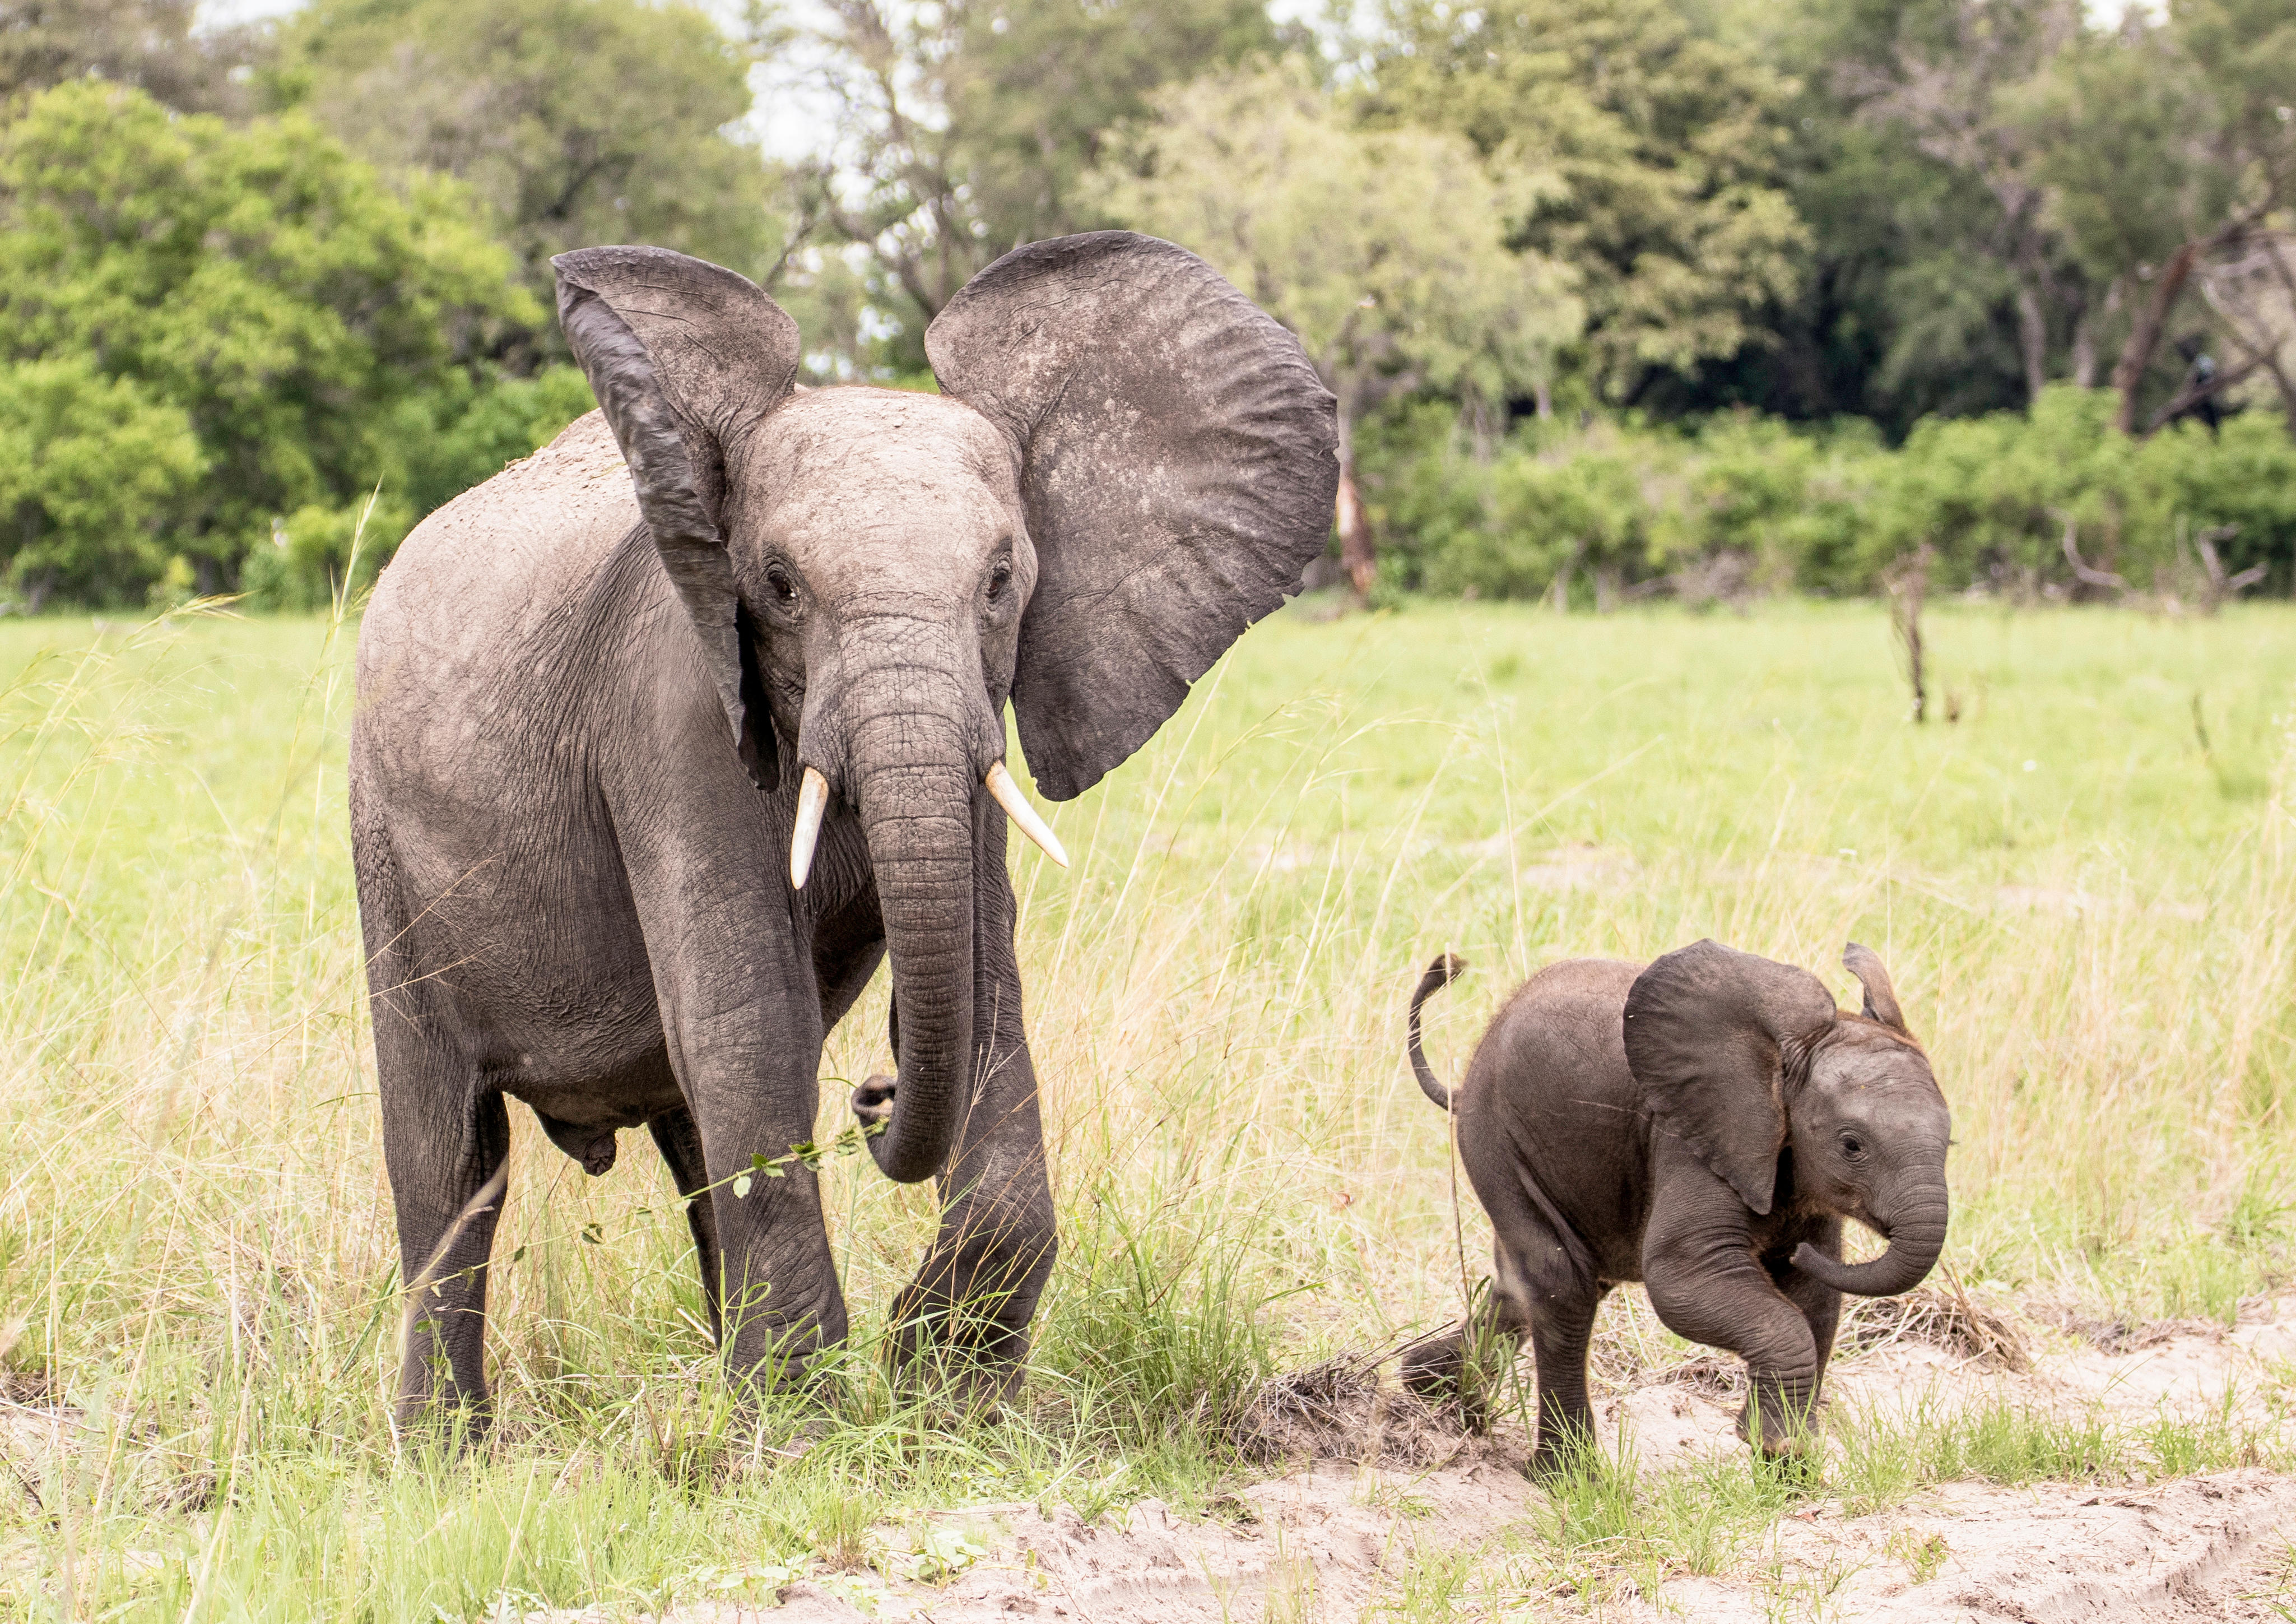

In [5]:
model_builder = tf.keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = tf.keras.applications.xception.preprocess_input
decode_predictions = tf.keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# img_path = tf.keras.utils.get_file(
#     "african_elephant.jpg", "https://static.scientificamerican.com/sciam/cache/file/065ACE5F-1E4B-4D3E-8E1E7CE0397D7681_source.jpg"
# )
img_path = "data/african_elephant.jpg"
display(Image(img_path))

In [6]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # make the grad model
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output,
                        model.output]
    )
    
    # compute the gradient
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [7]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

img_array.shape

(1, 299, 299, 3)

In [8]:
model = model_builder(weights="imagenet")
model.summary()

91889664/91884032 [==============================] - 13s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_________________________

In [9]:
model.layers[-1].activation = None

In [10]:
preds = model.predict(img_array)
print("Predicted: ", decode_predictions(preds, top=1)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted:  [('n02504458', 'African_elephant', 9.059033)]


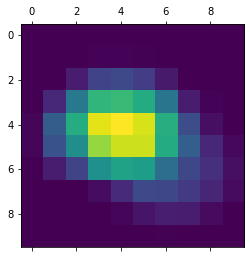

In [12]:
heat_map = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heat_map)
plt.show()

In [16]:
def save_and_display_gradcam(imgpath, heatmap, cam_path='cam.jpg', alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    heatmap = np.uint8(255 * heatmap)
    
    jet = cm.get_cmap("jet")
    
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
    super_imposed_img = jet_heatmap * alpha + img
    super_imposed_img = tf.keras.preprocessing.image.array_to_img(super_imposed_img)
    
    super_imposed_img.save(cam_path)
    
    display(Image(cam_path))

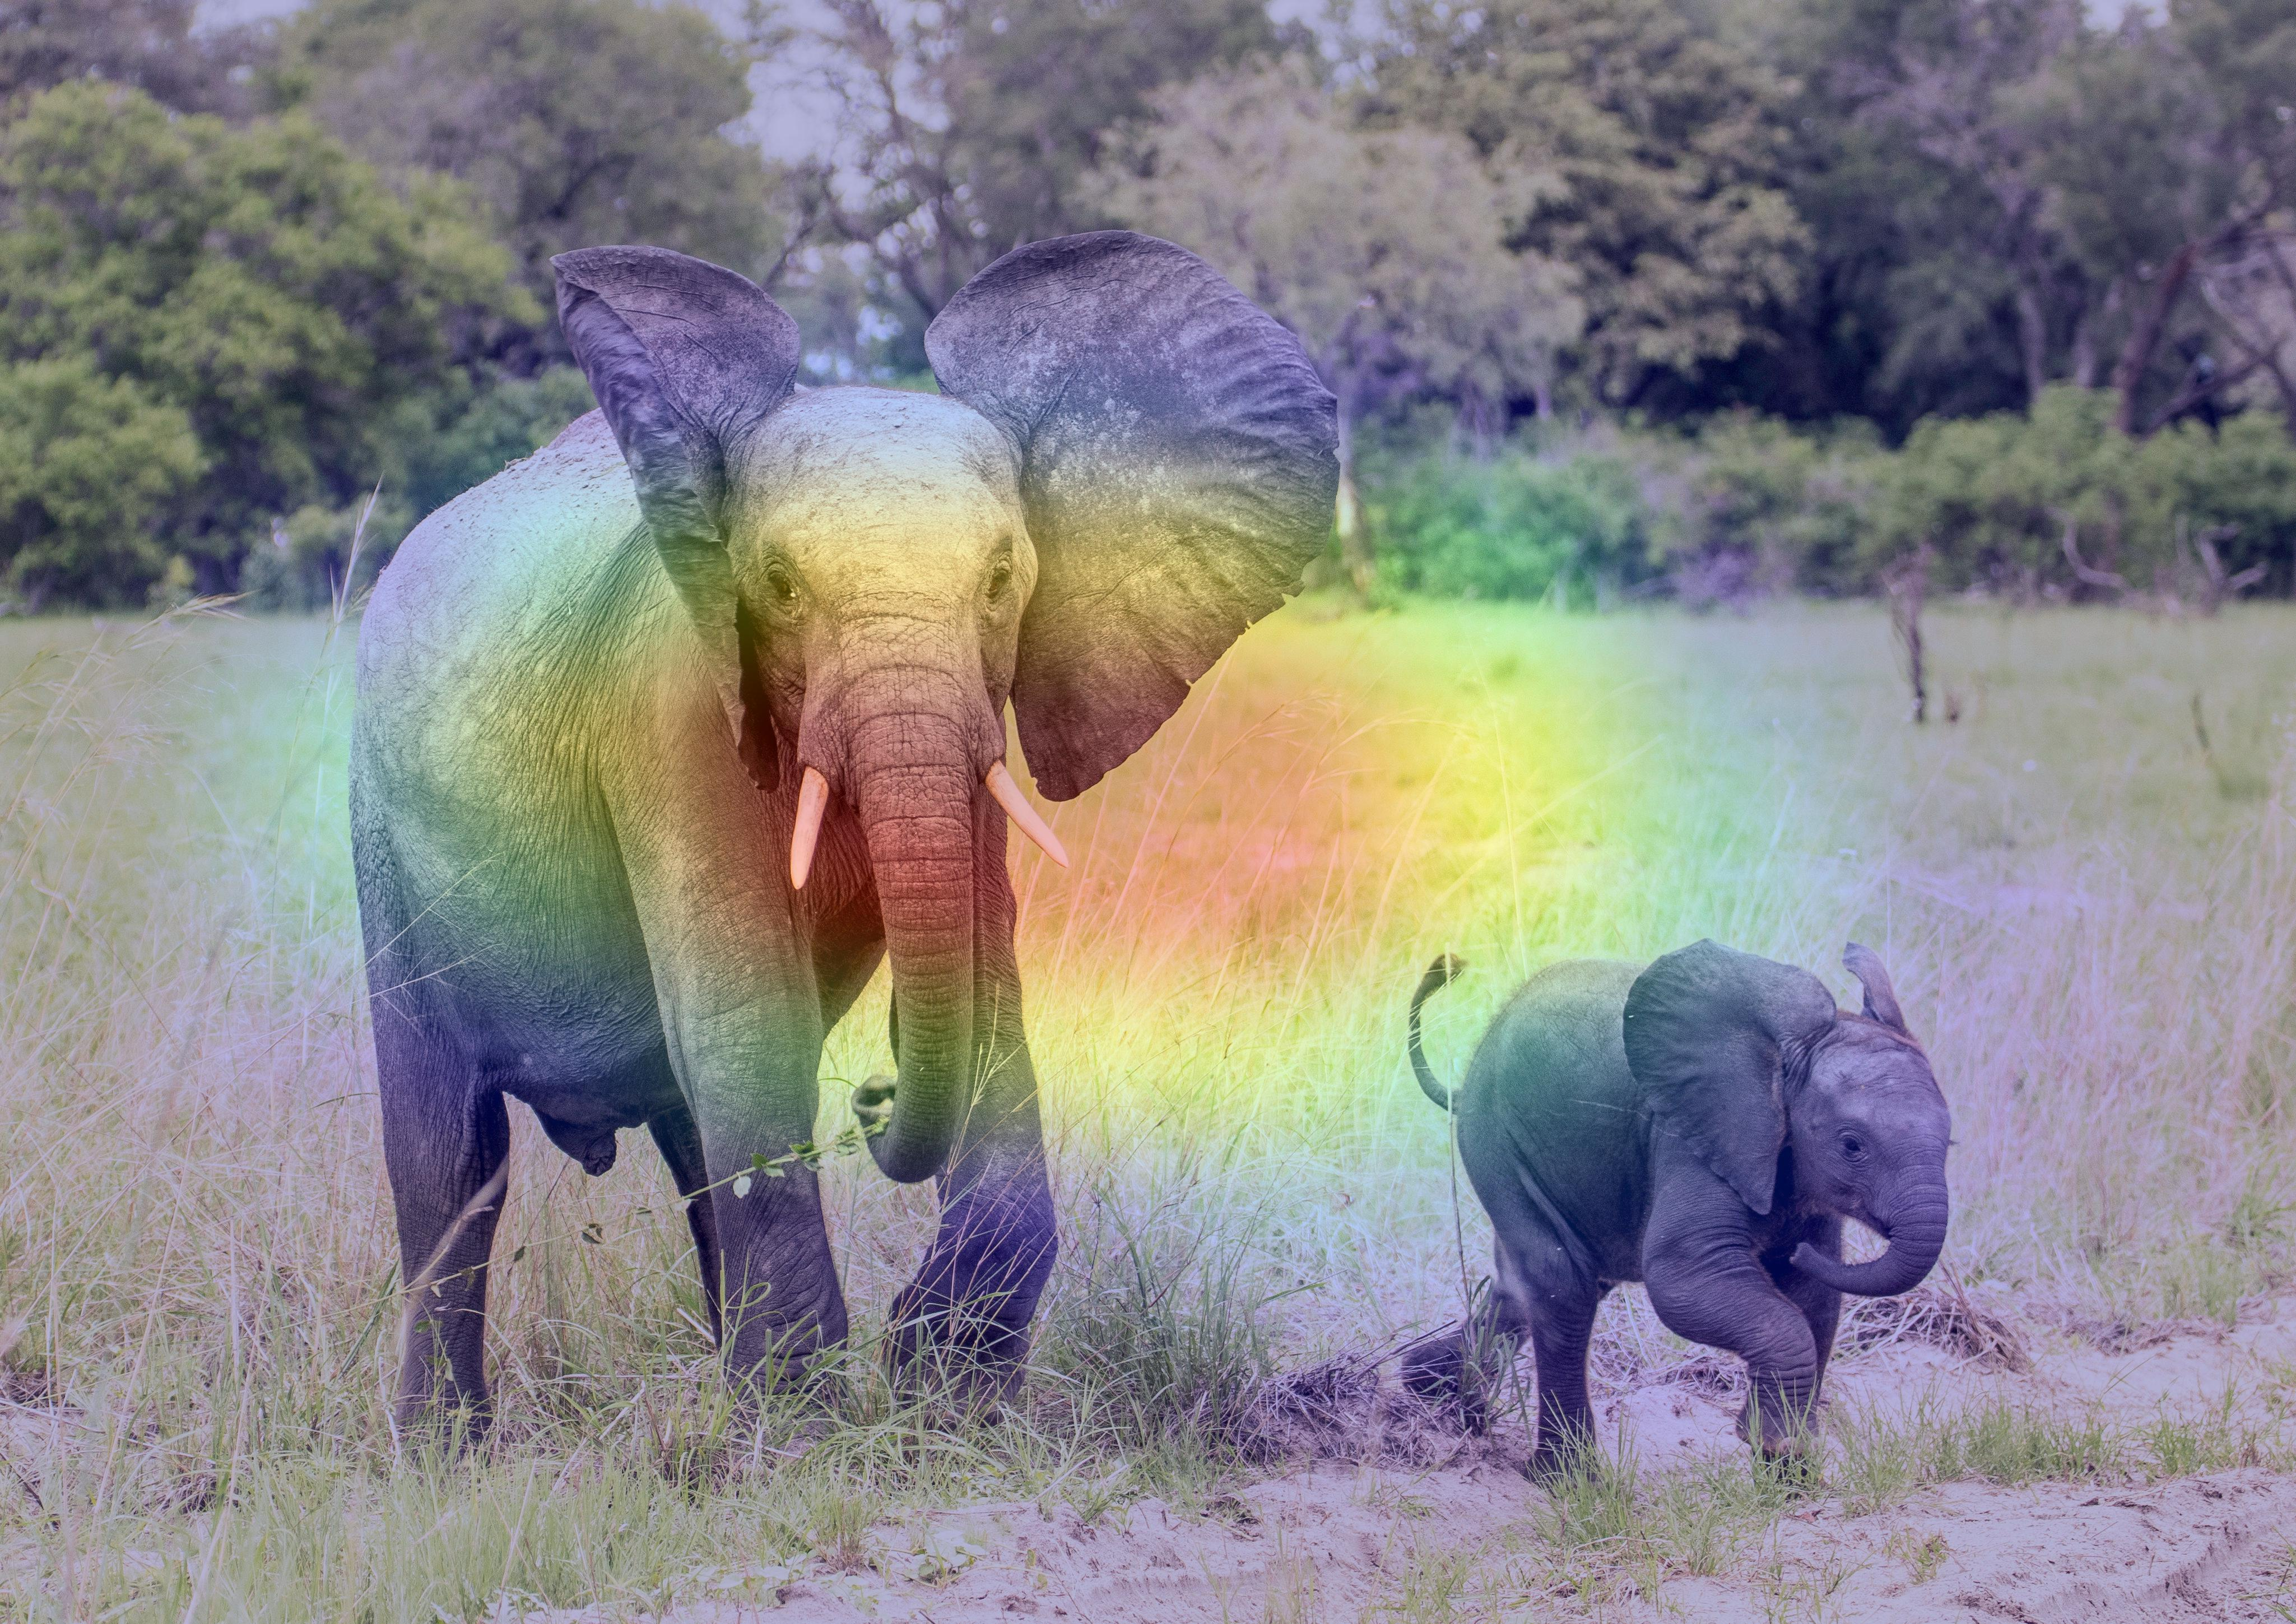

In [17]:
save_and_display_gradcam(img_path, heat_map)